In [1]:
# Importing all required sklearn libraries
import pandas as pd
import numpy as np
import re
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from dateutil import relativedelta
import seaborn as sns
sns.set_style("whitegrid")

In [35]:
location_boston = os.getcwd() + r'\archive_boston'
location_seattle = os.getcwd() + r'\archive_seattle'
city_dict = {'MA':'Boston','WA':'Seattle'}
month_dict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
fontsize_title = 10
fontsize_label = 8
fontsize_ticks = 8
fig_size = (8,3)

In [3]:
## Reading files
def read_file(filename,location):
    return pd.read_csv(location + '\\' + filename)  

## Identify columns that have only a single unique value
def filter_columns(df):
    required_cols = []
    for col in df.columns:
        if df[col].nunique() ==1:
            required_cols.append(col)
    return required_cols

## Identify columns that have less than 30% null values
def check_column_nullity(df):
    temp = df.isna().sum().reset_index()
    temp['more_than_30%_isnull'] = temp[0].apply(lambda x : False if x/df.shape[0] < 0.3 else True)
    return temp[temp['more_than_30%_isnull'] == True]['index'].unique().tolist()

## Identify columns with a particular pattern in their names e.g. columns that have 'url'
def identify_columns(df, pattern):
    pattern_cols = []
    for col in df.columns:
        if pattern.search(str(col).lower()):
            pattern_cols.append(col)
    return pattern_cols

#### Read Boston and Seattle AirBnb listings file and concatenate to make a single dataset

In [5]:
listings_boston = read_file('listings.csv',location_boston)
listings_seattle = read_file('listings.csv',location_seattle)
print(listings_boston.shape,listings_seattle.shape)
common_columns = list(set(listings_boston) & set(listings_seattle))
listings_df = pd.concat([listings_boston[common_columns],listings_seattle[common_columns]],axis=0)

(3585, 95) (3818, 92)


#### Read the Boston and Seattle AirBnb reviews files,concatenate and groupby listing_id, aggregated on max and min dates

In [7]:
reviews_boston = read_file('reviews.csv',location_boston)
reviews_seattle = read_file('reviews.csv',location_seattle)

reviews_df = pd.concat([reviews_boston,reviews_seattle],axis=0)
reviews_df['date'] = pd.to_datetime(reviews_df['date'],errors = 'coerce')
reviews = reviews_df.groupby('listing_id').agg(max_date = ('date','max'),min_date = ('date','min'),total_review_count = ('date','count')).reset_index()
reviews.drop_duplicates(inplace=True)
print(reviews.shape)

(6020, 4)


#### Read the Boston and Seattle AirBnb calendar files,select available entries and concatenate both

In [9]:
calendar_boston = read_file('calendar.csv',location_boston)
calendar_seattle = read_file('calendar.csv',location_seattle)
print(calendar_boston.shape,calendar_seattle.shape)
calendar_boston = calendar_boston[calendar_boston['available'] == 't']
calendar_seattle = calendar_seattle[calendar_seattle['available'] == 't']
print(calendar_boston.shape,calendar_seattle.shape)
print(calendar_boston.date.max(),calendar_seattle.date.max(),calendar_boston.date.min(),calendar_seattle.date.min())

(1308890, 4) (1393570, 4)
(643037, 4) (934542, 4)
2017-09-05 2017-01-02 2016-09-06 2016-01-04


In [10]:
calendar_df = pd.concat([calendar_boston,calendar_seattle],axis=0)
print(calendar_df.shape)
calendar_df.drop_duplicates(inplace=True)
print(calendar_df.shape)
print(calendar_df['date'].max(),calendar_df['date'].min())

(1577579, 4)
(1577499, 4)
2017-09-05 2016-01-04


In [11]:
### Checking nullity of listings columns
high_nullity_columns = check_column_nullity(listings_df)
### Checking columns with a constant value in listings
constant_value_columns = filter_columns(listings_df)

#### We will ignore the below columns in our analysis as they have high percentage of null values or have only a single constant value

In [13]:
print(high_nullity_columns + constant_value_columns)

['license', 'transit', 'neighbourhood_group_cleansed', 'weekly_price', 'jurisdiction_names', 'has_availability', 'monthly_price', 'notes', 'neighborhood_overview', 'square_feet', 'security_deposit', 'experiences_offered', 'country', 'jurisdiction_names', 'country_code', 'has_availability', 'requires_license']


In [18]:
### Finalised columns from listings data
data_columns = list(set(listings_df.columns) - set(constant_value_columns + high_nullity_columns))

In [19]:
print(data_columns)

['city', 'scrape_id', 'name', 'neighbourhood_cleansed', 'review_scores_location', 'space', 'host_identity_verified', 'host_id', 'host_is_superhost', 'host_listings_count', 'calendar_updated', 'review_scores_value', 'cleaning_fee', 'price', 'require_guest_profile_picture', 'review_scores_accuracy', 'xl_picture_url', 'instant_bookable', 'market', 'picture_url', 'medium_url', 'bed_type', 'number_of_reviews', 'bedrooms', 'beds', 'extra_people', 'last_review', 'reviews_per_month', 'host_url', 'availability_60', 'host_location', 'host_has_profile_pic', 'review_scores_checkin', 'host_verifications', 'listing_url', 'amenities', 'first_review', 'availability_30', 'longitude', 'neighbourhood', 'zipcode', 'host_response_rate', 'accommodates', 'require_guest_phone_verification', 'host_since', 'latitude', 'maximum_nights', 'id', 'review_scores_communication', 'host_response_time', 'smart_location', 'cancellation_policy', 'last_scraped', 'summary', 'thumbnail_url', 'host_total_listings_count', 'stat

#### Some Questions

#### 1. Does the listing pricing vary across cities and neighbourhoods within a city ?
#### 2. What kind of property_types and room_types are in high use based on reviews_per_month?
#### 3. What kind of amenities are associated with listings - based on reviews_per_month and review_scores_ratings ?
#### 4. How much influence do parameters like host_response_rate,host_response_time,host_since,host_acceptance_rate and cancellation_policy have on a listing's popularity? 

## 1. Does the listing pricing vary across cities and neighbourhoods within a city ?

In [22]:
listings_df['price'].head(2),calendar_df.price.head(2)

(0    $250.00
 1     $65.00
 Name: price, dtype: object,
 365    $65.00
 366    $65.00
 Name: price, dtype: object)

In [23]:
# The above columns need to be converted to numerical

In [24]:
listings = listings_df[data_columns]
listings['city_cleansed'] = listings['state'].apply(lambda x : city_dict[x.upper()])
listings['price'] = listings['price'].apply(lambda x : float(str(x).replace('$','').replace(',','')))
calendar_df.rename(columns = {'price':'calendar_price','date':'calendar_date'},inplace=True)
calendar_df['calendar_price'] = calendar_df['calendar_price'].apply(lambda x : float(str(x).replace('$','').replace(',','')))

In [27]:
listings['price'].describe() ### The pricing ranges from 10$ to 4000$

count    7403.000000
mean      150.227881
std       124.019680
min        10.000000
25%        79.000000
50%       120.000000
75%       190.000000
max      4000.000000
Name: price, dtype: float64

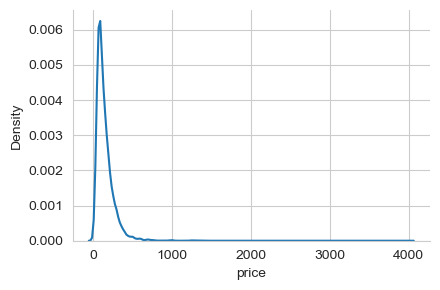

In [30]:
plot_ = sns.displot(listings['price'],height = 3,aspect=1.5,kind = 'kde')
### We can see that the avg price is ~ 150$ and there are outliers as shown in the below distribution and it's skewed to the right

In [52]:
listings['price'].isna().sum()

0

In [57]:
## Grouping the listings by city and aggregating by average price
data_city = listings.groupby('city_cleansed').agg(average_price = ('price','mean'),listing_count = ('id','count'),scraped_till_date = ('last_scraped','max')).reset_index()

In [58]:
data_city

,city_cleansed,average_price,listing_count,scraped_till_date
0,Boston,173.925802,3585,2016-09-07
1,Seattle,127.976166,3818,2016-01-04


### 1. We can see that Boston has a lower listing count but a higher average price even though it's been scraped till Sep 2016 as opposed to Seattle's Jan 2016

### Let's check the fluctuation in the average price per month of listings in both the cities
#### Merge the calendar data with the listing on listing id and group the resulting dataframe on id,year and month and aggregate on price, add the city and neighbourhood facets

In [62]:
available_listing_price = pd.merge(calendar_df,listings[['id','state']],left_on='listing_id',right_on = 'id').drop_duplicates()
available_listing_price['calendar_date'] = pd.to_datetime(available_listing_price['calendar_date'],errors='coerce')
available_listing_price['Month'] = available_listing_price['calendar_date'].dt.month
available_listing_price['Year'] = available_listing_price['calendar_date'].dt.year

temp_x = available_listing_price.groupby(['listing_id','Year','Month']).agg(avg_price_month = ('calendar_price','mean')).reset_index()
temp_y = pd.merge(temp_x,listings[['id','city_cleansed','neighbourhood_cleansed']],left_on = 'listing_id',right_on = 'id').drop_duplicates()
temp_z = temp_y.groupby(['Year','Month']).agg(listing_count = ('listing_id','count'),avg_monthly_price = ('avg_price_month','mean'),
                                              city = ('city_cleansed','max')).reset_index()

temp_z['Month'] = temp_z['Month'].apply(lambda x : month_dict[x])
temp_z['Year'] = temp_z['Year'].astype(str)
temp_z['Time'] = temp_z['Month'] + ' ' + temp_z['Year']

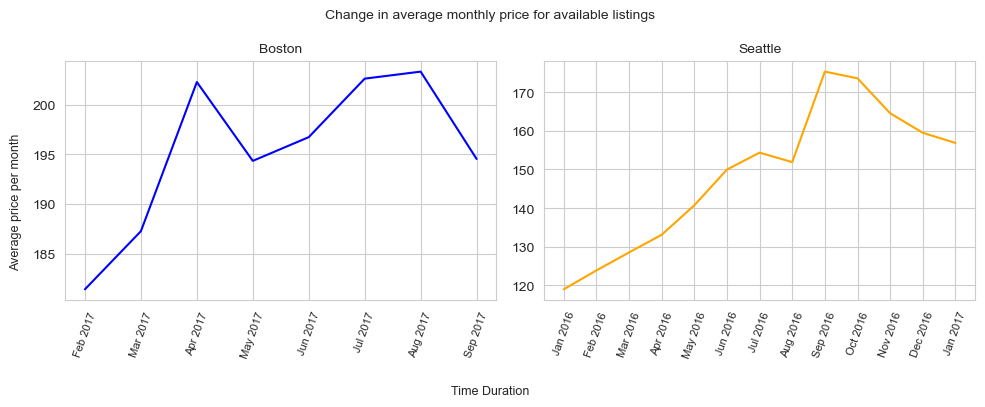

In [91]:
fontsize_title = 10
fontsize_suplabel = 9
fontsize_ticks = 8
rotation = 70

fig, axes = plt.subplots(1,2,figsize=(10,4))
fig.suptitle('Change in average monthly price for available listings',fontsize = fontsize_title)
fig.supxlabel('Time Duration',fontsize = fontsize_suplabel)
fig.supylabel('Average price per month',fontsize = fontsize_suplabel)

plot1 = sns.lineplot(x = "Time", y = "avg_monthly_price", data = temp_z[temp_z['city'] == 'Boston'],color='blue',ax=axes[0])
plot1.set_title('Boston',fontsize = 10)
plot1.set_xticklabels(labels = temp_z[temp_z['city'] == 'Boston']['Time'].unique(), rotation=rotation,fontsize = fontsize_ticks)
plot2 = sns.lineplot(x = "Time", y = "avg_monthly_price", data = temp_z[temp_z['city'] == 'Seattle'],color = "orange", ax=axes[1])
plot2.set_title('Seattle',fontsize = 10)
plot2.set_xticklabels(labels = temp_z[temp_z['city'] == 'Seattle']['Time'].unique(), rotation=rotation,fontsize = fontsize_ticks)

plot1.set_xlabel(None)
plot2.set_xlabel(None)
plot1.set_ylabel(None)
plot2.set_ylabel(None)

fig.tight_layout()
plt.show()

### 1.1 Feb 2017 has the lowest avg. price while Apr,Jul and Aug 2017 are high for Boston
### 1.2 Jan 2016 has the lowest avg. price while Sep,Oct 2016 are high for Seattle
## The start of the year does seem to have lower avg prices compared to the rest of the year in both sets, could be because of the holidays

### Let's examine the price distribution within neighbourhoods of each city

In [69]:
## Grouping the listings by neighbourhoods and aggregating by average price
data_neighbourhood_boston = listings[listings['city_cleansed'] == 'Boston'].groupby(['neighbourhood_cleansed']).agg(average_price = ('price','mean')).sort_values('average_price',ascending=False).reset_index().head(10)
data_neighbourhood_seattle = listings[listings['city_cleansed'] == 'Seattle'].groupby(['neighbourhood_cleansed']).agg(average_price = ('price','mean')).sort_values('average_price',ascending=False).reset_index().head(10)
data_neighbourhood = listings.groupby(['neighbourhood_cleansed','city_cleansed']).agg(average_price = ('price','mean')).sort_values('average_price',ascending=False).reset_index().head(20)
neighbourhood_boston = data_neighbourhood_boston.sort_values('average_price',ascending=False).neighbourhood_cleansed.unique().tolist()
neighbourhood_seattle = data_neighbourhood_seattle.sort_values('average_price',ascending=False).neighbourhood_cleansed.unique().tolist()
neighbourhood = data_neighbourhood.sort_values('average_price',ascending=False).neighbourhood_cleansed.unique().tolist()


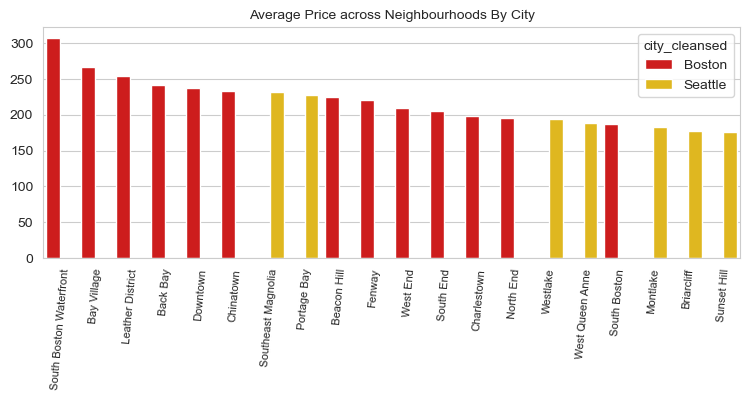

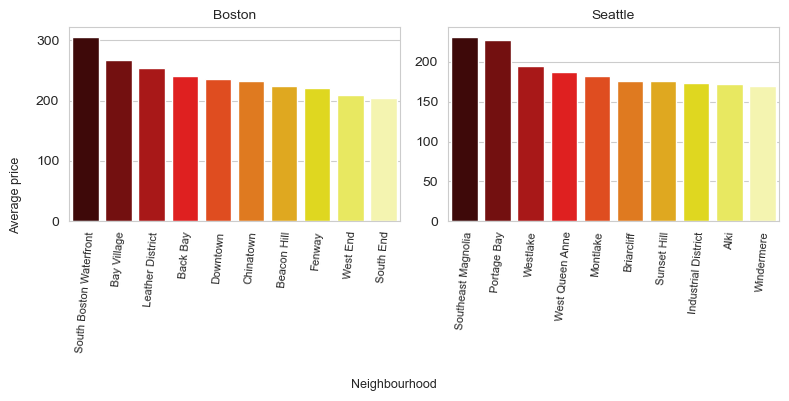

In [92]:
fontsize_title = 10
fontsize_suplabel = 9
fontsize_ticks = 8
rotation = 85

plt.figure(figsize = (9,3))

plot3 = sns.barplot(data=data_neighbourhood,x='neighbourhood_cleansed',y = 'average_price',hue = 'city_cleansed',palette = 'hot')
plot3.set_xticklabels(labels = neighbourhood,rotation=85,fontsize = fontsize_ticks)
plot3.set_title('Average Price across Neighbourhoods By City',fontsize = fontsize_title)
plot3.set_xlabel(None)
plot3.set_ylabel(None)

plt.show()

fig, axes = plt.subplots(1,2,figsize=(8,4))
fig.supxlabel('Neighbourhood',fontsize = fontsize_suplabel)
fig.supylabel('Average price',fontsize = fontsize_suplabel)
plot1 = sns.barplot(data=data_neighbourhood_boston,x='neighbourhood_cleansed',y = 'average_price',ax=axes[0],palette = 'hot')
plot1.set_xticklabels(labels = neighbourhood_boston,rotation=85,fontsize = fontsize_ticks)
plot1.set_title('Boston',fontsize = fontsize_title)

plot2 = sns.barplot(data=data_neighbourhood_seattle,x='neighbourhood_cleansed',y = 'average_price',ax=axes[1],palette = 'hot')
plot2.set_xticklabels(labels = neighbourhood_seattle,rotation=85,fontsize = fontsize_ticks)
plot2.set_title('Seattle',fontsize = fontsize_title)


plot1.set_xlabel(None)
plot2.set_xlabel(None)
plot1.set_ylabel(None)
plot2.set_ylabel(None)

fig.tight_layout()




### 1. The Boston neighbourhoods are pricier than Seattle ones
### 2. South Boston Waterfront is the priciest neighbourhood in Boston 
### 3. Southeast Magnolia & Portage Bay are the priciest for Seattle

## Overall it would be more lucrative to own a listing in Boston as compared to Seattle

## 2. What kind of property types and room types are in high use based on reviews per month?

In [94]:
reviews.head(2)

,listing_id,max_date,min_date,total_review_count
0,3353,2016-08-24,2009-04-23,34
1,4291,2015-10-18,2013-07-01,35


In [95]:
### Setting the start and end dates for extracting 2 years reviews using max date of the concatenated reviews
duration = 24 #in months
reviews_max_date = reviews.max_date.max()
date_two_years_back = reviews_max_date - pd.DateOffset(months=duration)

In [96]:
reviews['has_past_two_years_data'] = np.where((reviews['min_date'] >= date_two_years_back) & (reviews['max_date'] >= date_two_years_back),True,False)
two_year_ids = reviews[reviews['has_past_two_years_data'] == True].listing_id.unique()
temp = reviews_df[reviews_df['listing_id'].isin(two_year_ids)]
temp['has_two_years_data'] = np.where(temp['date']>=date_two_years_back,True,False)
temp.drop_duplicates(inplace=True)
temp_x = temp.groupby('listing_id').agg(two_year_count = ('date','count')).reset_index()
reviews = pd.merge(reviews,temp_x,on='listing_id')

In [99]:
data = pd.merge(listings,reviews[['listing_id','total_review_count','two_year_count']],left_on = 'id',right_on='listing_id')

In [100]:
boston_accomodation_df = data[data['neighbourhood_cleansed'].isin(neighbourhood_boston)].groupby(['property_type','room_type']).agg(total_count_two_year_reviews = ('two_year_count','sum')).sort_values(['total_count_two_year_reviews'],ascending=False).reset_index().head(5)
overall_boston_accomodation_df = data[data['city_cleansed'] == 'Boston'].groupby(['property_type','room_type']).agg(total_count_two_year_reviews = ('two_year_count','sum')).sort_values(['total_count_two_year_reviews'],ascending=False).reset_index().head(5)
seattle_accomodation_df = data[data['neighbourhood_cleansed'].isin(neighbourhood_seattle)].groupby(['property_type','room_type']).agg(total_count_two_year_reviews = ('two_year_count','sum')).sort_values(['total_count_two_year_reviews'],ascending=False).reset_index().head(5)
overall_seattle_accomodation_df = data[data['city_cleansed'] == 'Seattle'].groupby(['property_type','room_type']).agg(total_count_two_year_reviews = ('two_year_count','sum')).sort_values(['total_count_two_year_reviews'],ascending=False).reset_index().head(5)

In [101]:
boston_accomodation_df['property_room_type'] = boston_accomodation_df['property_type'] +'_with_'+ boston_accomodation_df['room_type']
overall_boston_accomodation_df['property_room_type'] = overall_boston_accomodation_df['property_type'] +'_with_'+ overall_boston_accomodation_df['room_type']
seattle_accomodation_df['property_room_type'] = seattle_accomodation_df['property_type'] +'_with_'+ seattle_accomodation_df['room_type']
overall_seattle_accomodation_df['property_room_type'] = overall_seattle_accomodation_df['property_type'] +'_with_'+ overall_seattle_accomodation_df['room_type']

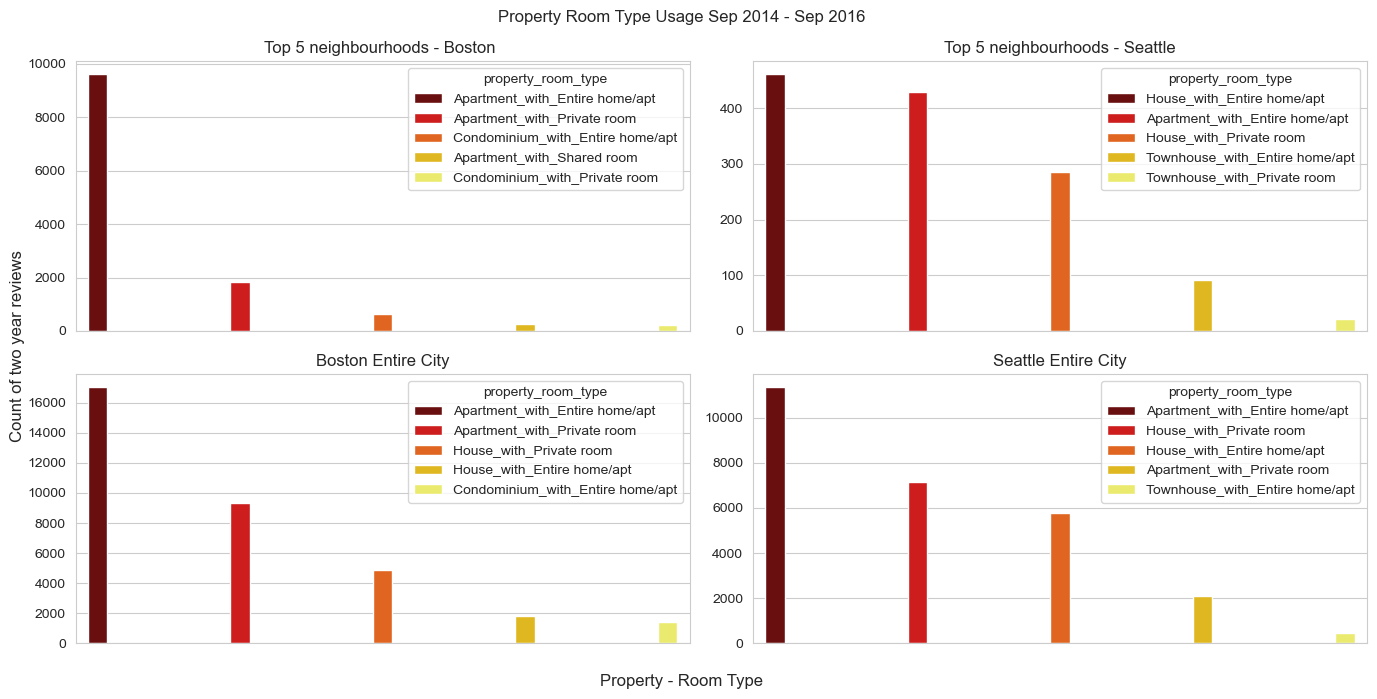

In [109]:
labels = []
fontsize_title = 12
fontsize_suplabel = 12
fontsize_ticks = 8
rotation = 85


fig, axes = plt.subplots(2, 2,figsize=(14,7))
fig.suptitle("Property Room Type Usage Sep 2014 - Sep 2016",fontsize=fontsize_title)
fig.supxlabel('Property - Room Type',fontsize=fontsize_suplabel)
fig.supylabel('Count of two year reviews',fontsize=fontsize_suplabel)

plot1 = sns.barplot(data=boston_accomodation_df,x='property_room_type',y = 'total_count_two_year_reviews',hue='property_room_type',ax=axes[0][0],palette = 'hot')
plot1.set_title('Top 5 neighbourhoods - Boston ' ,fontsize=fontsize_title)
plot1.set_xticklabels(labels= labels)
plot1.set_xlabel(None)
plot1.set_ylabel(None)

plot2 = sns.barplot(data=seattle_accomodation_df,x='property_room_type',y = 'total_count_two_year_reviews',hue='property_room_type',ax=axes[0][1],palette = 'hot')
plot2.set_title('Top 5 neighbourhoods - Seattle',fontsize=fontsize_title)
plot2.set_xticklabels(labels= labels)
plot2.set_xlabel(None)
plot2.set_ylabel(None)

plot3 = sns.barplot(data=overall_boston_accomodation_df,x='property_room_type',y = 'total_count_two_year_reviews',hue='property_room_type',ax=axes[1][0],palette = 'hot')
plot3.set_title('Boston Entire City' ,fontsize=fontsize_title)
plot3.set_xticklabels(labels= labels)
plot3.set_xlabel(None)
plot3.set_ylabel(None)

plot4 = sns.barplot(data=overall_seattle_accomodation_df,x='property_room_type',y = 'total_count_two_year_reviews',hue='property_room_type',ax=axes[1][1],palette = 'hot')
plot4.set_xticklabels(labels= labels)
plot4.set_title('Seattle Entire City',fontsize=fontsize_title)
plot4.set_xlabel(None)
plot4.set_ylabel(None)
fig.tight_layout()
plt.show()

### 1. In the top priced boston neighbourhoods entire apartment is very popular
###  2. In the top priced seattle neighbourhoods entire house and apartment are very popular
### 3. The same pattern for each is observed in their respective overall plots as well, however the proportion of entire home/apartment in seattle is very small compared to the overall seattle data whereas for boston the proportion of entire apartment is high in the top priced neighbourhoods

### Entire apartments are popular across both cities

#### 3. What kind of amenities are associated with listings - based on reviews_per_month and review_scores_ratings ?

In [122]:
### We will use the last two years (2016 - 2014) data for both seattle and boston

listings['last_review'] = pd.to_datetime(listings['last_review'],errors='coerce')
max_review_date = listings['last_review'].max()
two_years_back =  max_review_date - pd.DateOffset(months=duration)

In [123]:
listings[listings['city_cleansed'] == 'Boston'].last_review.max(),listings[listings['city_cleansed'] == 'Seattle'].last_review.max()

(Timestamp('2016-09-06 00:00:00'), Timestamp('2016-01-03 00:00:00'))

In [124]:
data_boston = listings[(listings['city_cleansed'] == 'Boston') & (listings['last_review'] >= two_years_back) & (listings['last_review'] < max_review_date)][['id','amenities','review_scores_rating','last_review','number_of_reviews']]
temp_boston = data_boston.copy()
temp_boston['amenities_deconstructed'] = temp_boston['amenities'].apply(lambda x : re.sub('["{}\s]','',x).split(','))
print(temp_boston.shape)
temp_boston = temp_boston.explode('amenities_deconstructed')[['id','review_scores_rating','number_of_reviews','amenities_deconstructed']].drop_duplicates()
print(temp_boston.shape)

data_seattle = listings[(listings['city_cleansed'] == 'Seattle') & (listings['last_review'] >= two_years_back) & (listings['last_review'] < max_review_date)][['id','amenities','review_scores_rating','last_review','number_of_reviews']]
temp_seattle = data_seattle.copy()
temp_seattle['amenities_deconstructed'] = temp_seattle['amenities'].apply(lambda x : re.sub('["{}\s]','',x).split(','))
print(temp_seattle.shape)
temp_seattle = temp_seattle.explode('amenities_deconstructed')[['id','review_scores_rating','number_of_reviews','amenities_deconstructed']].drop_duplicates()
print(temp_seattle.shape)

(2734, 6)
(43967, 4)
(3142, 6)
(45482, 4)


In [125]:
## Removing some unusual entries
patterns = {'translationmissing:en.hosting_amenity_50':0,
            'translationmissing:en.hosting_amenity_49':0,'':0}
temp_boston['amenities_deconstructed'] = temp_boston['amenities_deconstructed'].apply(lambda c : patterns[c] if c in patterns.keys() else c)
temp_seattle['amenities_deconstructed'] = temp_seattle['amenities_deconstructed'].apply(lambda c : patterns[c] if c in patterns.keys() else c)

In [126]:
### Grouping the data by amenities, aggregated by listing count for each,total number of reviews and avg review scores rating

data_plot_boston = temp_boston.groupby('amenities_deconstructed').agg(listing_counts = ('id','count'),
                                   total_number_of_reviews = ('number_of_reviews','sum'),
                                   avg_review_scores_rating = ('review_scores_rating','mean'))\
.sort_values('listing_counts',ascending=False).reset_index()
data_plot_boston.drop_duplicates(inplace=True)
print(data_plot_boston.shape)

data_plot_seattle = temp_seattle.groupby('amenities_deconstructed').agg(listing_counts = ('id','count'),
                                   total_number_of_reviews = ('number_of_reviews','sum'),
                                   avg_review_scores_rating = ('review_scores_rating','mean'))\
.sort_values('listing_counts',ascending=False).reset_index()
data_plot_seattle.drop_duplicates(inplace=True)
print(data_plot_seattle.shape)

(44, 4)
(42, 4)


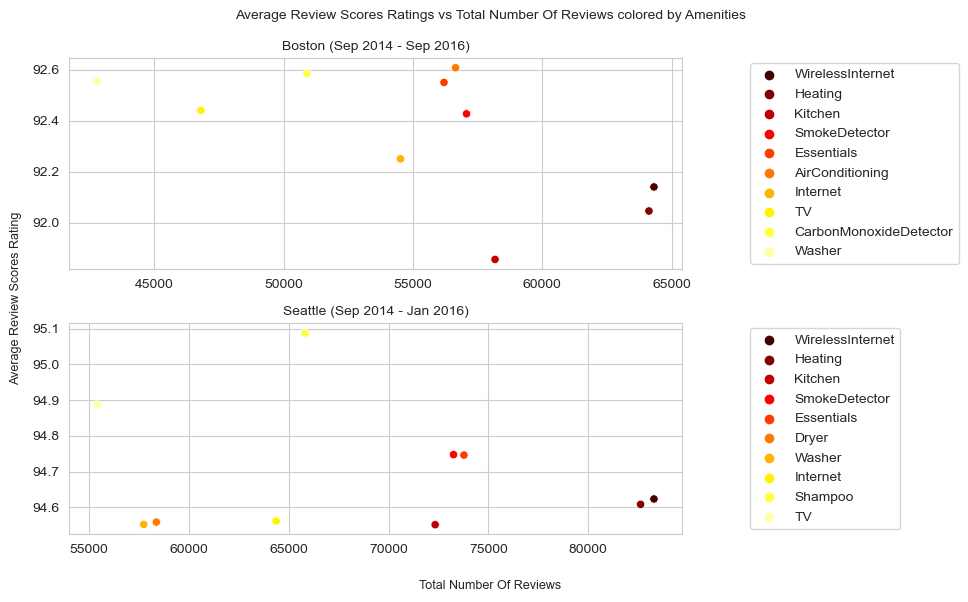

In [127]:
fontsize_title = 10
fontsize_suplabel = 9
fontsize_ticks = 8
rotation = 85

fig, axes = plt.subplots(2, 1,figsize=(10,6))
fig.suptitle('Average Review Scores Ratings vs Total Number Of Reviews colored by Amenities',fontsize=fontsize_title)
fig.supxlabel('Total Number Of Reviews',fontsize= fontsize_suplabel)
fig.supylabel('Average Review Scores Rating',fontsize= fontsize_suplabel)

plot1 = sns.scatterplot(data=data_plot_boston.head(10),x='total_number_of_reviews',y = 'avg_review_scores_rating',hue = 'amenities_deconstructed',palette='hot',ax = axes[0])
plot1.set_title('Boston (Sep 2014 - Sep 2016)' ,fontsize=fontsize_title)
plot1.legend(loc='center left', bbox_to_anchor=(1.1,.5), ncol=1)
plot1.set_xlabel(None)
plot1.set_ylabel(None)

plot2 = sns.scatterplot(data=data_plot_seattle.head(10),x='total_number_of_reviews',y = 'avg_review_scores_rating',hue = 'amenities_deconstructed',palette='hot',ax = axes[1])
plot2.set_title('Seattle (Sep 2014 - Jan 2016)' ,fontsize=fontsize_title)
plot2.legend(loc='center left', bbox_to_anchor=(1.1,.5), ncol=1,fontsize=10)
plot2.set_xlabel(None)
plot2.set_ylabel(None)

fig.tight_layout()
plt.show()

### 1. The first five amenities (WirelessInternet,Heating,Kitchen,SmokeDetector,Essentials) are common to both cities and are attached to a very large number of listings
### 2. The avg review scores rating also seem to be very good for these 5

### It would be safe to assume that the first five seem to be staple for a basic listing
### AirConditioning doesn't seem as important in Boston as well as shampoo, wonder why???

## 4. How much influence do parameters like host_response_rate,host_response_time,host_since,host_acceptance_rate and cancellation_policy have on a listing's popularity? 

In [128]:
listings['number_of_reviews'].describe()

count    7403.000000
mean       20.684047
std        36.733024
min         0.000000
25%         1.000000
50%         7.000000
75%        23.000000
max       474.000000
Name: number_of_reviews, dtype: float64

### Let's focus on listings that have at least a 100 reviews

In [129]:
data = listings[listings['number_of_reviews']>=100][['id','review_scores_rating','host_response_time','host_acceptance_rate','host_listings_count','host_response_rate','host_since','cancellation_policy','city_cleansed','last_review','number_of_reviews']]
print(data.shape,data.id.nunique())
data = data[data['review_scores_rating'].notna()]
print(data.shape,data.id.nunique())

(298, 11) 298
(298, 11) 298


In [130]:
## Removing special characters and converting to numerical
data['host_response_rate'] = data['host_response_rate'].apply(lambda x:int(str(x).replace('%','').strip()) if str(x)!='nan' else -1)
data['host_acceptance_rate'] = data['host_acceptance_rate'].apply(lambda x:int(str(x).replace('%','').strip()) if str(x)!='nan' else -1)
data['host_since'] = pd.to_datetime(data['host_since'],errors='coerce')
data['host_since_year'] = data['host_since'].dt.year

In [131]:
data['number_of_reviews'].max(),data['number_of_reviews'].min()

(474, 100)

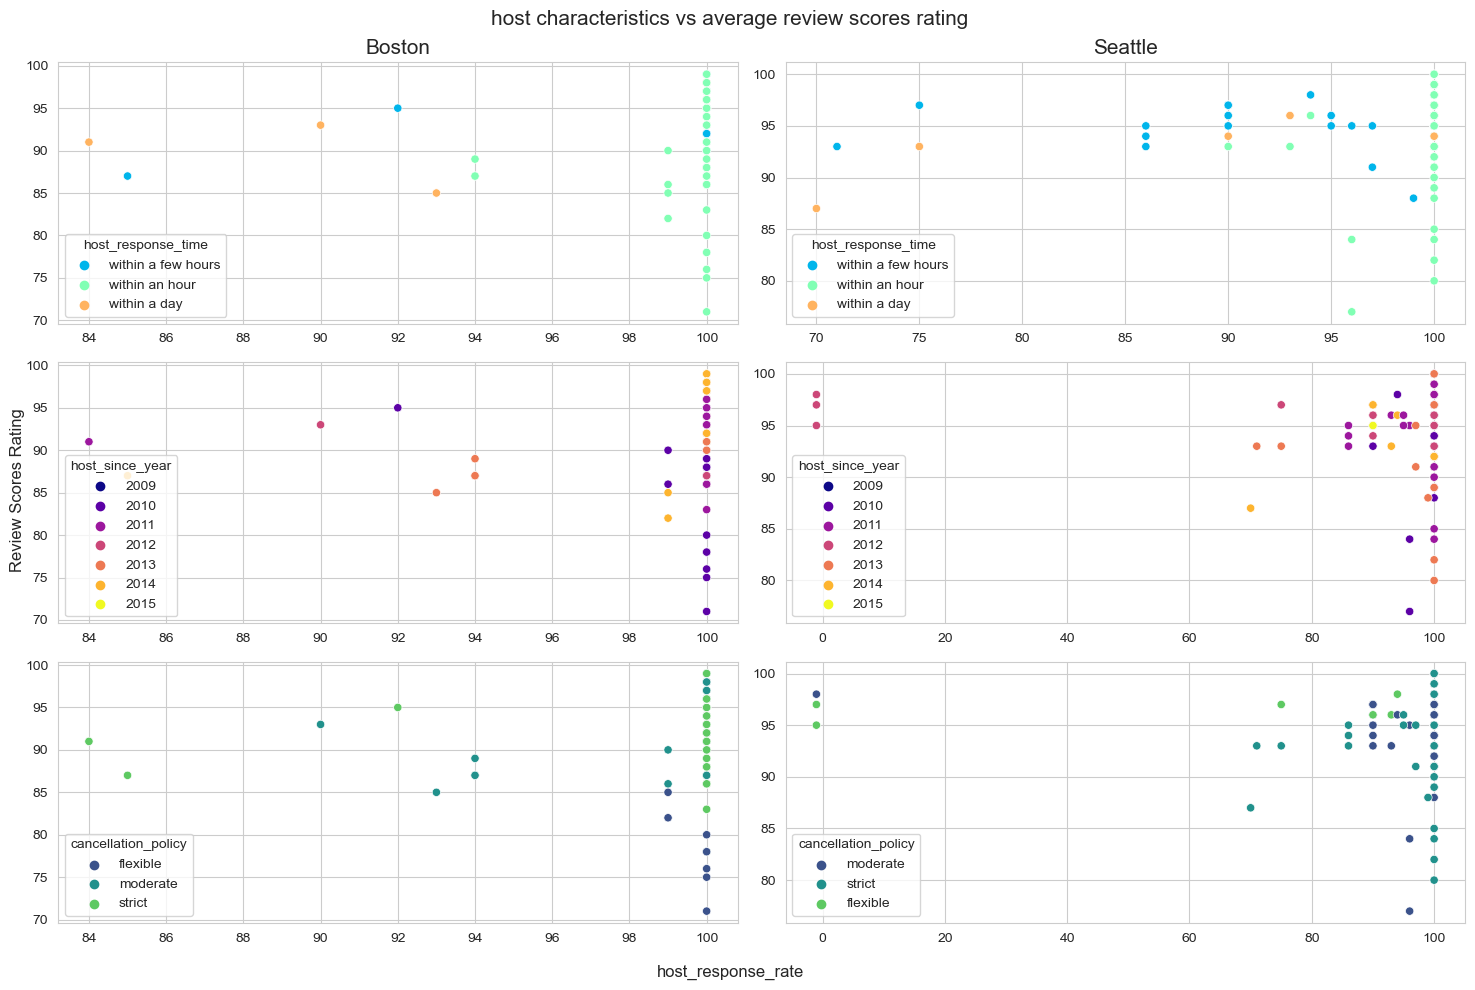

In [149]:
fontsize_title = 15
fontsize_suplabel = 12
fontsize_ticks = 9
rotation = 85

fig, axes = plt.subplots(3,2,figsize=(15,10))

fig.suptitle('host characteristics vs average review scores rating',fontsize = fontsize_title)
fig.supylabel('Review Scores Rating',fontsize = fontsize_suplabel)
fig.supxlabel('host_response_rate',fontsize = fontsize_suplabel)


plot1 = sns.scatterplot(data=data[data['city_cleansed'] == 'Boston'],x='host_response_rate',y = 'review_scores_rating',hue = 'host_response_time',ax=axes[0][0],palette='rainbow')
plot2 = sns.scatterplot(data=data[data['city_cleansed'] == 'Seattle'],x='host_response_rate',y = 'review_scores_rating',hue = 'host_response_time',ax=axes[0][1],palette='rainbow')
plot3 = sns.scatterplot(data=data[data['city_cleansed'] == 'Boston'],x='host_response_rate',y = 'review_scores_rating',hue = 'host_since_year',ax=axes[1][0],palette='plasma')
plot4 = sns.scatterplot(data=data[data['city_cleansed'] == 'Seattle'],x='host_response_rate',y = 'review_scores_rating',hue = 'host_since_year',ax=axes[1][1],palette='plasma')
plot5 = sns.scatterplot(data=data[data['city_cleansed'] == 'Boston'],x='host_response_rate',y = 'review_scores_rating',hue = 'cancellation_policy',ax=axes[2][0],palette='viridis')
plot6 = sns.scatterplot(data=data[data['city_cleansed'] == 'Seattle'],x='host_response_rate',y = 'review_scores_rating',hue = 'cancellation_policy',ax=axes[2][1],palette='viridis')

plot1.set_title('Boston',fontsize = fontsize_title)
plot2.set_title('Seattle',fontsize = fontsize_title)

plot1.set_ylabel(None)
plot2.set_ylabel(None)
plot3.set_ylabel(None)
plot4.set_ylabel(None)
plot5.set_ylabel(None)
plot6.set_ylabel(None)


plot1.set_xlabel(None)
plot2.set_xlabel(None)
plot3.set_xlabel(None)
plot4.set_xlabel(None)
plot5.set_xlabel(None)
plot6.set_xlabel(None)

fig.tight_layout()
plt.show()

In [148]:
### 1. Upper right corner of the first two subplots shows that "within an hour" responses have higher scores for both seattle and boston and even "a few hours" is good enough for seattle
### 2. There doesn't seem to be any specific pattern for host since year, older as well as recent hosts seem to respond at higher rates , no pattern for ratings as well based on host since year
### 3. Hosts with "moderate" & "strict" policies seem to have higher review ratings for Boston while it's an equal mix for Seattle, no hosts with very strict policies are seen in the plots


### In order to be a good host, need to have a good response time typically within an hour or hew hours at least, have a relaxation on the cancellation policies as well, the hosts longevity on the field doesn't seem important int this data